In [1]:
### Neural Network Model
### Monthly prediction
## no shuffle of data
### no Lookback

In [2]:
import sys
sys.path.append('/home/jovyan/work/')
sys.path.append('/home/jovyan/work/src')
sys.path.append('/home/jovyan/work/src/data')
sys.path.append('/home/jovyan/work/src/data_explore')
sys.path.append('/home/jovyan/work/src/features')
sys.path.append('/home/jovyan/work/src/models')
sys.path.append('/home/jovyan/work/src/analysis')


In [3]:
print(sys.path)

['/home/jovyan/work/notebooks', '/opt/conda/lib/python311.zip', '/opt/conda/lib/python3.11', '/opt/conda/lib/python3.11/lib-dynload', '', '/opt/conda/lib/python3.11/site-packages', '/home/jovyan/work/', '/home/jovyan/work/src', '/home/jovyan/work/src/data', '/home/jovyan/work/src/data_explore', '/home/jovyan/work/src/features', '/home/jovyan/work/src/models', '/home/jovyan/work/src/analysis']


In [4]:
from src import data,data_explore,features
from data import create_input_data
from data_explore import explore_util
from features import build_features
from models import train_model,predict_model
from analysis import analyze_pred

In [5]:
def get_jobs_in_range(dfq,start,end):
    df1=dfq.query('submit >= @start and submit < @end')
    return df1

In [6]:
df_arr={}
df_jan = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Jan2022_1Feb2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['jan'] = df_jan
df_feb_aug = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Feb2022_1Aug2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['feb']= get_jobs_in_range(df_feb_aug,"2022-02-01","2022-03-01")
df_arr['march']= get_jobs_in_range(df_feb_aug,"2022-03-01","2022-04-01")
df_arr['april']= get_jobs_in_range(df_feb_aug,"2022-04-01","2022-05-01")
df_arr['may'] = get_jobs_in_range(df_feb_aug,"2022-05-01","2022-06-01")
df_arr['june'] = get_jobs_in_range(df_feb_aug,"2022-06-01","2022-07-01")
df_arr['july'] = get_jobs_in_range(df_feb_aug,"2022-07-01","2022-08-01")
df_arr['august'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Aug2022_1Sept2022normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['sept'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Sept2022_1Oct2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['oct'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Oct2022_1Nov2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['nov'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Nov2022_1Dec2022_normal_sorted.csv", parse_dates_col=[4,5,6])
df_arr['dec'] = create_input_data.read_data(csv_file_name="../data/raw/anon_jobs_1Dec2022_1Jan2023_normal_sorted.csv", parse_dates_col=[4,5,6])

In [8]:
def train_test_data(month):
    X_historydata = df_arr[month]
    ## remove default columns
    df = build_features.remove_default_cols(df_arr[month])
    Y_waittimedata = df['queue_minutes']
    X_historydata= build_features.remove_cols(df,['queue_minutes','run_minutes'])
    return X_historydata, Y_waittimedata

In [9]:
from importlib import reload
reload(train_model)
def train_model_NN(X_historydata_norm, Y_waittimedata_train):
    epochs=500
    batch_size=32
    validation_spilt=0.2
    model = train_model.create_default_model(input_shape=7)
    early_stopping_cb = train_model.set_early_stopping()
    model, hist = train_model.train_model_no_shuffle(X_historydata_norm, Y_waittimedata_train, model, early_stopping_cb,epochs=epochs, batch_size=batch_size, validation_spilt=0.2)
    return model, hist

In [10]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def predict_evaluate(model,scaler,X_historydata_test,Y_waittimedata_test):
    y_pred=model.predict(scaler.transform(X_historydata_test))
    y_pred = np.where(y_pred<0,0,y_pred)
    r2s = r2_score(Y_waittimedata_test.to_numpy(),y_pred)
    mse = mean_squared_error(Y_waittimedata_test.to_numpy(),y_pred,squared=False)
    mae = mean_absolute_error(Y_waittimedata_test.to_numpy(),y_pred)
    return y_pred, r2s, mse, mae

In [11]:
from sklearn.linear_model import LinearRegression
from importlib import reload
import numpy as np
reload(analyze_pred)
reload(build_features)
train_months=['jan','feb','march','april','may','june','july','august','sept','oct']
predict_months=['feb','march','april','may','june','july','august','sept','oct','nov']
results=[]
for i in range(0,10):
    result = {}
    result['train_month']= train_months[i]
    result['predict_month']= predict_months[i]
    X_historydata_train, Y_waittimedata_train = train_test_data(train_months[i])
    X_historydata_test, Y_waittimedata_test = train_test_data(predict_months[i])
    X_historydata_norm, scaler = build_features.standardization(X_historydata_train)
    model, hist = train_model_NN(X_historydata_norm, Y_waittimedata_train)
    y_pred, r2s, mse, mae = predict_evaluate(model,scaler,X_historydata_test,Y_waittimedata_test)
    #provision_time = 20
    provision_time = 45 
    tolerance_factor = 3
    provision_time, n_scheduled, n_missed, no_missed, wrongly_scheduled, t_num = analyze_pred.analysis_short(0,Y_waittimedata_test.shape[0], Y_waittimedata_test, y_pred.ravel(),
                                                                                                          provision_time=provision_time, tolerance_factor=tolerance_factor)
    
    result['ideally_sched'] = n_scheduled
    result['missed'] = n_missed

    result['wrongly_sched'] = wrongly_scheduled
    result['total_num'] = t_num
    result['%_wrongly_sched'] = (wrongly_scheduled/t_num)*100
    result['%_ideally_sched'] = (n_scheduled/t_num)*100
    result['%_missed_oppor.'] = (n_missed/n_scheduled)*100
    result['t_wrong_sched_%'] = (wrongly_scheduled/(wrongly_scheduled + no_missed))*100
    result['r2s'] = r2s
    result['mse'] = mse
    result['mae'] = mae
    result['provision_time'] = provision_time
    #result['model_score'] = model_score
    #result['model'] = lreg
    result['y_pred'] = y_pred
    #result['not_missed'] = no_missed
    #result['provision_time'] = provision_time
    results.append(result)
    #print(result)
    #print("\n")


Model: "queueTime"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden1 (Dense)             (None, 30)                240       
                                                                 
 Hidden2 (Dense)             (None, 100)               3100      
                                                                 
 Hidden3 (Dense)             (None, 100)               10100     
                                                                 
 Output (Dense)              (None, 1)                 101       
                                                                 
Total params: 13,541
Trainable params: 13,541
Non-trainable params: 0
_________________________________________________________________
None
1127/1127 [==============================] - 0s 396us/step
Model: "queueTime"
_________________________________________________________________
 Layer (type)                Output 

/tmp/ipykernel_2999/2280644773.py:32: RuntimeWarning: invalid value encountered in long_scalars
  result['t_wrong_sched_%'] = (wrongly_scheduled/(wrongly_scheduled + no_missed))*100


Model: "queueTime"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden1 (Dense)             (None, 30)                240       
                                                                 
 Hidden2 (Dense)             (None, 100)               3100      
                                                                 
 Hidden3 (Dense)             (None, 100)               10100     
                                                                 
 Output (Dense)              (None, 1)                 101       
                                                                 
Total params: 13,541
Trainable params: 13,541
Non-trainable params: 0
_________________________________________________________________
None
2466/2466 [==============================] - 1s 396us/step
Model: "queueTime"
_________________________________________________________________
 Layer (type)                Output 

/tmp/ipykernel_2999/2280644773.py:32: RuntimeWarning: invalid value encountered in long_scalars
  result['t_wrong_sched_%'] = (wrongly_scheduled/(wrongly_scheduled + no_missed))*100


In [12]:
reload(analyze_pred)
rdf = analyze_pred.add_all_to_df(results)

In [13]:
rdf

,train_month,predict_month,ideally_sched,missed,wrongly_sched,total_num,%_wrongly_sched,%_ideally_sched,%_missed_oppor.,t_wrong_sched_%,r2s,mse,mae,provision_time,y_pred
0,jan,feb,12854,6016,4343,36043,12.049496,35.662958,46.802552,38.842680,0.015544,786.046662,254.145335,45,"[[76.46564], [48.99321], [39.723034], [76.1078..."
1,feb,march,16178,6,24182,44846,53.922312,36.074566,0.037087,59.924667,0.033845,495.346671,244.550872,45,"[[234.0281], [234.0281], [234.49156], [234.955..."
2,march,april,4253,3322,2609,62427,4.179281,6.812757,78.109570,73.700565,-0.019654,221.383471,43.842445,45,"[[0.0], [25.934708], [233.14127], [233.73523],..."
3,april,may,1990,1873,1,55544,0.001800,3.582745,94.120603,0.847458,0.029438,258.515834,37.935083,45,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
4,may,june,7455,3234,6784,57031,11.895285,13.071838,43.380282,61.644707,0.012949,196.866906,103.956189,45,"[[110.28403], [105.453], [106.48427], [112.019..."
5,june,july,2840,143,12164,67325,18.067583,4.218344,5.035211,81.851827,0.089786,673.861462,173.120924,45,"[[14.342448], [4.3646717], [4.3646717], [10.95..."
6,july,august,9048,9048,0,69801,0.000000,12.962565,100.000000,NaN,-0.030018,582.206331,130.693237,45,"[[48.6324], [48.731266], [48.830128], [48.9289..."
7,august,sept,4056,3931,5664,78908,7.177979,5.140163,96.918146,97.840732,-0.098080,500.293899,113.650902,45,"[[781.2834], [781.2834], [0.0], [0.0], [0.0], ..."
8,sept,oct,2896,2862,25,41664,0.060004,6.950845,98.825967,42.372881,-0.007312,270.010188,45.515865,45,"[[90.08393], [90.32565], [101.02092], [101.020..."
9,oct,nov,2215,2215,0,55530,0.000000,3.988835,100.000000,NaN,-0.023325,113.776008,20.037211,45,"[[5.2565417], [3.6199148], [0.0], [0.0], [0.51..."


In [14]:
# write to file
from pathlib import Path  
filepath = Path('../data/processed/month_prediction_nolookback_nn_anon_jan-nov22_prov45.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
rdf.to_csv(filepath,index=False)

Text(0, 0.5, 'Total Number of Wrong Scheduled Jobs')

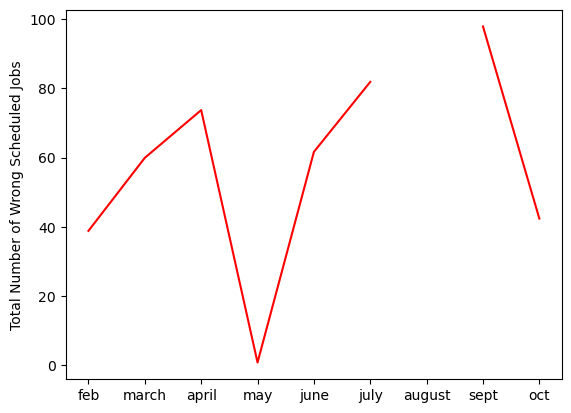

In [15]:
import matplotlib.pyplot as plt
t_wrong_sched= [] 


for i in range(0,10):
    t_wrong_sched.append(results[i]['t_wrong_sched_%'])
plt.plot(predict_months,t_wrong_sched,'r')
plt.ylabel('Total Number of Wrong Scheduled Jobs')

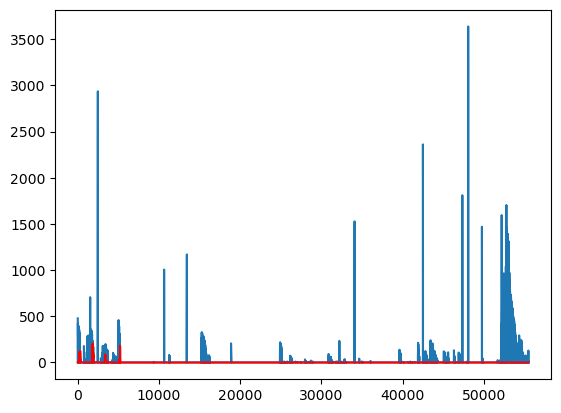

In [58]:
plt.plot(df_arr['nov']['queue_minutes'].to_numpy())
plt.plot(results[9]['y_pred'],'r')

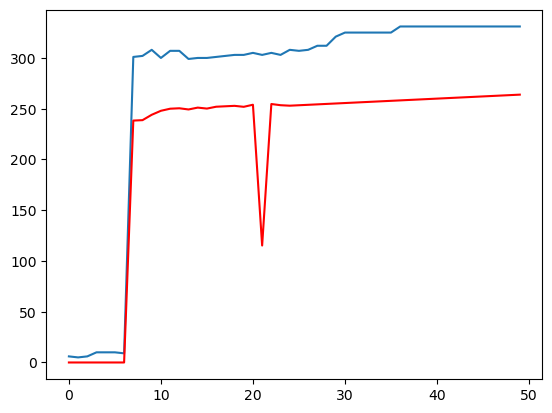

In [41]:

plt.plot(df_arr['april']['queue_minutes'].to_numpy()[150:200])
plt.plot(results[2]['y_pred'][150:200],'r')

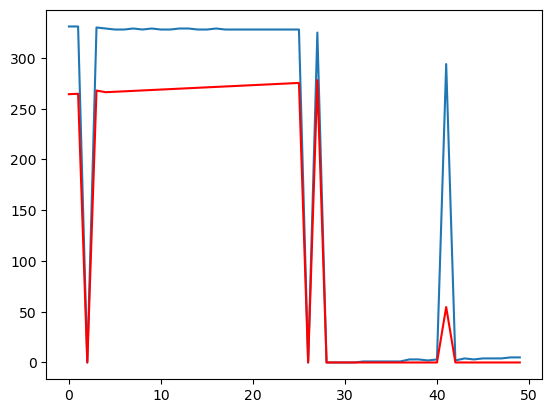

In [42]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[200:250])
plt.plot(results[2]['y_pred'][200:250],'r')

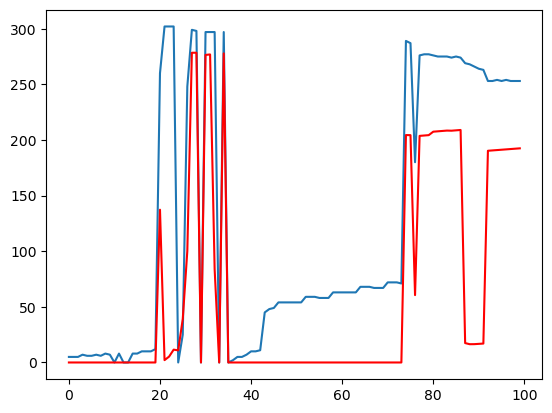

In [43]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[250:350])
plt.plot(results[2]['y_pred'][250:350],'r')

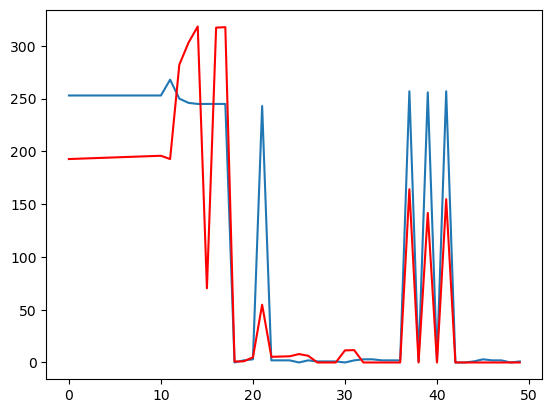

In [44]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[350:400])
plt.plot(results[2]['y_pred'][350:400],'r')

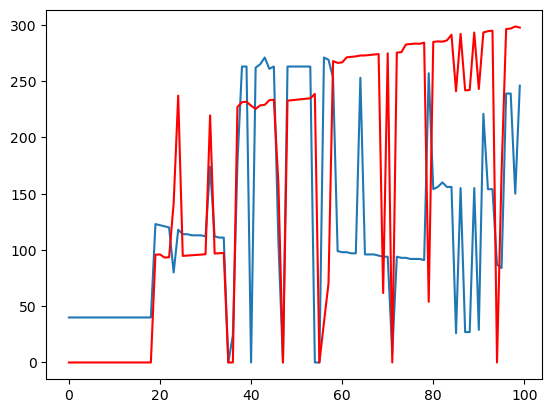

In [45]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[1250:1350])
plt.plot(results[2]['y_pred'][1250:1350],'r')

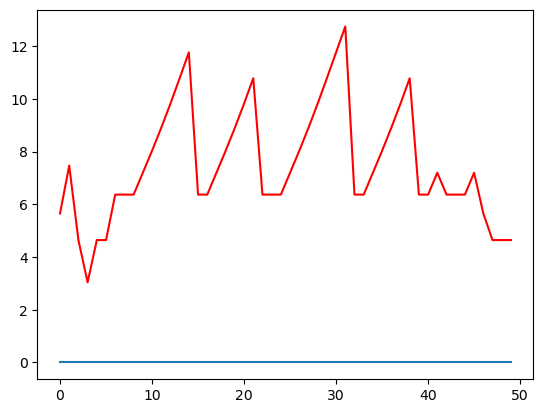

In [46]:
import matplotlib.pyplot as plt
plt.plot(df_arr['july']['queue_minutes'].to_numpy()[150:200])
plt.plot(results[5]['y_pred'][150:200],'r')

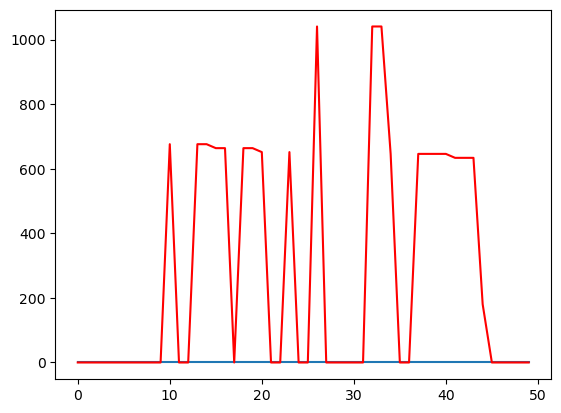

In [24]:
import matplotlib.pyplot as plt
plt.plot(df_arr['sept']['queue_minutes'].to_numpy()[150:200])
plt.plot(results[7]['y_pred'][150:200],'r')

In [29]:
from sklearn import linear_model
alpha_list = [0.00001,0.0001, 0.001, 0.005,0.01, 0.025, 0.05,0.1, 0.5,1, 1.5,2,5]
pred=[]
for alpha in alpha_list:
    clf = linear_model.Lasso(alpha)
    clf.fit(X_historydata_norm,Y_waittimedata_train)
    y_pred3 = clf.predict(scaler.transform(X_historydata_test))
    #dis = np.linalg.norm(y_pred3-Y_waittimedata_test)
    score = clf.score(X_historydata_norm,Y_waittimedata_train)
    pred.append(score)
    print("alpha: " + str(alpha) + " score: " + str(score))
    print("coefficients: " + str(clf.coef_))

alpha: 1e-05 score: 0.15055777192734532
coefficients: [1259.29533719  181.89957571  412.53005077  326.95756577   78.17413341
 -217.05857691  102.0698538   106.42995386  823.49652068  -25.8302958
 -202.42857618   70.44905082 -443.90831659  600.31653789   82.63488198
  -41.26535236 -164.84239664  446.96611493 -217.69600671 -121.77145131
  164.3136722   147.58830623 -136.8719604  -136.23428418  178.75038215
 -299.4255282    39.30998659  123.58797808    2.51498085 -177.44946075
   89.15737264  192.55514429 -168.32194664  -40.91525132  441.00426946
   -7.14151301  -31.84663995  -61.99765465   79.77187515   50.84894414
   47.56140217 -175.86440199]
alpha: 0.0001 score: 0.15055777080921795
coefficients: [1259.0606489   181.93380756  412.52972799  326.95874789   78.17100144
 -217.03651388  102.04929995  106.42149005  823.40063253  -25.72242134
 -202.36366049   70.34045707 -443.78877315  600.23378193   82.54656759
  -41.18075302 -164.75635204  446.82912401 -217.63449719 -121.69376825
  164.2844

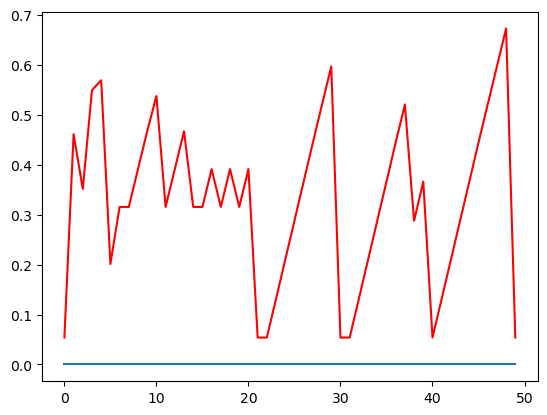

In [31]:
reload(predict_model)
predict_model.compare_plots_pred_vs_true(Y_waittimedata_test, y_pred, 150, 200)

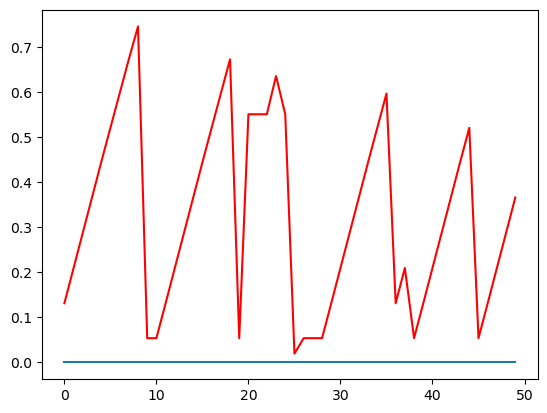

In [32]:
predict_model.compare_plots_pred_vs_true(Y_waittimedata_test, y_pred, 200,250)


In [33]:
predict_model.inspect_test_data(X_historydata_test,Y_waittimedata_test,y_pred,207,210, "set 1: 207: 210")
predict_model.inspect_test_data(X_historydata_test,Y_waittimedata_test,y_pred,225,228, "set2: 225-228")
predict_model.inspect_test_data(X_historydata_test,Y_waittimedata_test,y_pred,228, 231, "set3: 228-231")

------------------set 1: 207: 210-----------------------
qm test:[0 0 0]
qm pred:[0.6728473  0.74569976 0.05392192]
X test:       reqcpus  nnodes  max_minutes  backlog_minutes  backlog_num_jobs  \
59398       64       1           25             6080                11   
59399       64       1           25             6105                12   
59400       64       1           25             5880                 3   

       running_num_jobs  running_minutes  qm1  qm2  qm3  ...  qm26  qm27  \
59398             23371         10012710    0    0    0  ...     0     0   
59399             23371         10012710    0    0    0  ...     0     0   
59400             23371         10012710    0    0    0  ...     0     0   

       qm28  qm29  qm30  qm31  qm32  qm33  qm34  qm35  
59398     0     0     0     0     0     0     0     0  
59399     0     0     0     0     0     0     0     0  
59400     0     0     0     0     0     0     0     0  

[3 rows x 42 columns]
----------------------------

In [34]:
print(X_historydata_test_rm)
run_mins = X_historydata_test_rm["run_minutes"]
run_mins = run_mins.to_numpy()
print("run_minutes" + str(run_mins))
nnodes = X_historydata_test["nnodes"]
nnodes = nnodes.to_numpy()
print(" nnodes : " + str(nnodes))


       reqcpus  nnodes  max_minutes  backlog_minutes  backlog_num_jobs  \
59191       64       1           25             5880                 3   
59192       64       1           25             5880                 3   
59193       64       1           25             5905                 4   
59194       64       1           25             5880                 3   
59195       64       1           25             5905                 4   
...        ...     ...          ...              ...               ...   
78903      120       5           40           719877               265   
78904      120       5           40           719917               266   
78905      120       5           40           719957               267   
78906      120       5           40           719997               268   
78907      120       5           40           720037               269   

       running_num_jobs  running_minutes  run_minutes  qm1  qm2  ...  qm26  \
59191             23371         1

In [35]:
reload(analyze_pred)
analyze_pred.analysis_pred_vs_orig(2000,200, Y_waittimedata_test, y_pred.ravel(), nnodes,run_mins,
                                   provision_time=20, tolerance_factor=3, print_flag=0)

Criteria 3: User desires a job to be dynamically scheduled : if actual_qtime> n*provision_time where n=3 
 provision_time in mins= 20: scheduled?
0    200
Name: count, dtype: int64
Criteria 4: Missed opportunity: if (predicted_qtime < n*provision_time) and  actual_qtime > n*provision_time: missed?
0    200
Name: count, dtype: int64


KeyError: 1

In [36]:
reload(analyze_pred)
analyze_pred.analysis_pred_vs_orig(0,80554, Y_waittimedata_test, y_pred.ravel(), nnodes,run_mins,
                                   provision_time=20, tolerance_factor=3, print_flag=0)

Criteria 3: User desires a job to be dynamically scheduled : if actual_qtime> n*provision_time where n=3 
 provision_time in mins= 20: scheduled?
0    14787
1     4930
Name: count, dtype: int64
Criteria 4: Missed opportunity: if (predicted_qtime < n*provision_time) and  actual_qtime > n*provision_time: missed?
0    16216
m     3501
Name: count, dtype: int64
Criteria 4: Not Missed opportunity: 4930-3501=1429

 Criteria 5: Wrongly Scheduled : wrongly_scheduled?
0    19303
1      414
Name: count, dtype: int64


In [31]:
analyze_pred.analysis_pred_vs_orig(0,80554, Y_waittimedata_test, y_pred.ravel(), nnodes,run_mins,
                                   provision_time=45, tolerance_factor=3, print_flag=0)

Criteria 3: User desires a job to be dynamically scheduled : if actual_qtime> n*provision_time where n=3 
 provision_time in mins= 45: scheduled?
0    13946
1     2636
Name: count, dtype: int64
Criteria 4: Missed opportunity: if (predicted_qtime < n*provision_time) and  actual_qtime > n*provision_time: missed?
0    16254
m      328
Name: count, dtype: int64
Criteria 4: Not Missed opportunity: 2636-328=2308

 Criteria 5: Wrongly Scheduled : wrongly_scheduled?
1    9415
0    7167
Name: count, dtype: int64


In [32]:
analyze_pred.analysis_pred_vs_orig(0,80554, Y_waittimedata_test, y_pred.ravel(), nnodes,run_mins,
                                   provision_time=60, tolerance_factor=3, print_flag=0)

Criteria 3: User desires a job to be dynamically scheduled : if actual_qtime> n*provision_time where n=3 
 provision_time in mins= 60: scheduled?
0    14138
1     2444
Name: count, dtype: int64
Criteria 4: Missed opportunity: if (predicted_qtime < n*provision_time) and  actual_qtime > n*provision_time: missed?
0    15818
m      764
Name: count, dtype: int64
Criteria 4: Not Missed opportunity: 2444-764=1680

 Criteria 5: Wrongly Scheduled : wrongly_scheduled?
0    9176
1    7406
Name: count, dtype: int64


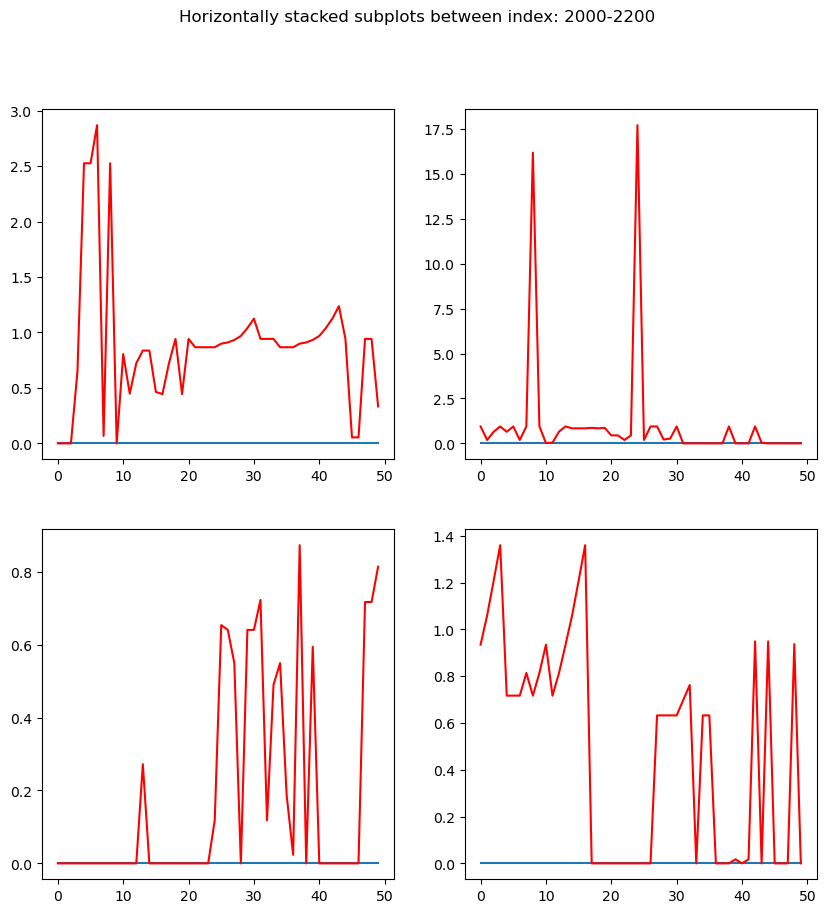

In [37]:
reload(analyze_pred)
analyze_pred.plot_pred_vs_orig(2000,50,Y_waittimedata_test,y_pred.ravel())

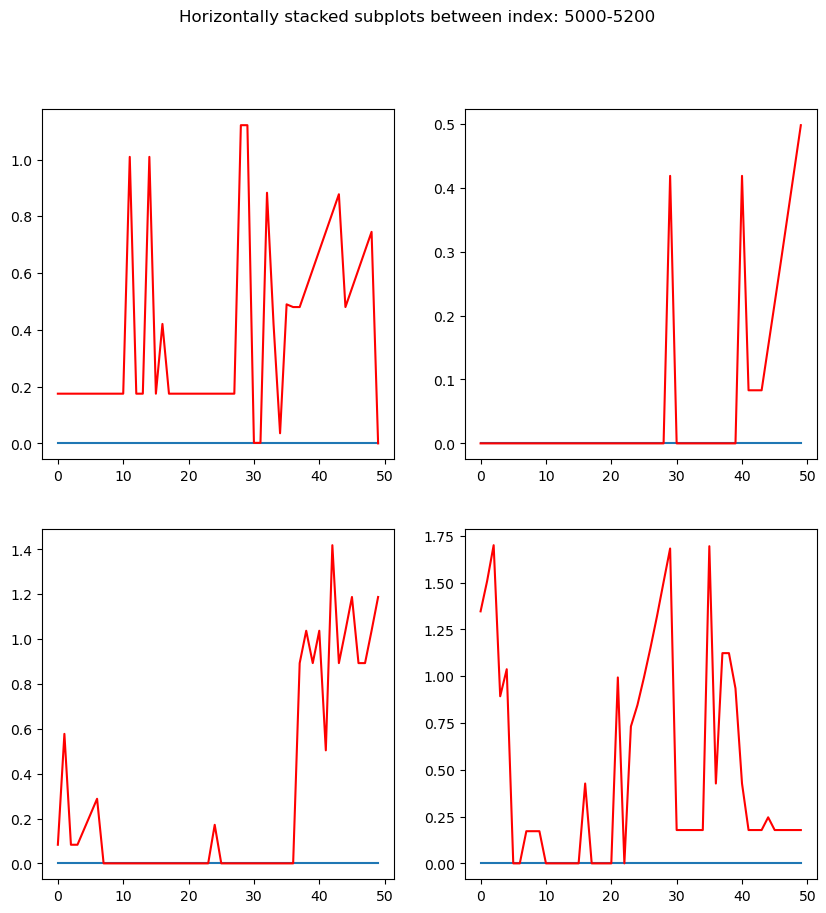

In [38]:
analyze_pred.plot_pred_vs_orig(5000,50,Y_waittimedata_test,y_pred.ravel())

In [39]:
from sklearn.metrics import r2_score
r2_score(Y_waittimedata_test.to_numpy(),y_pred)

-0.058118622918922114

In [36]:
df25 = create_input_data.read_data(csv_file_name="../data/processed/correct_anon_aug_sept_past2022_35_completed_qm.csv", parse_dates_col=[4,5,6])

In [37]:
df25 = build_features.remove_default_cols(df25)
df25

,reqcpus,nnodes,max_minutes,queue_minutes,backlog_minutes,backlog_num_jobs,running_num_jobs,running_minutes,run_minutes,qm1,...,qm26,qm27,qm28,qm29,qm30,qm31,qm32,qm33,qm34,qm35
0,48,1,120,1,898116,393,22918,9692906,38,0,...,0,0,0,0,0,0,0,0,0,0
1,48,1,120,1,898236,394,22918,9692906,38,0,...,0,0,0,0,0,0,0,0,0,0
2,48,1,120,1,898356,395,22918,9692906,44,0,...,0,0,0,0,0,0,0,0,0,0
3,48,1,120,1,898476,396,22918,9692906,41,0,...,0,0,0,0,0,0,0,0,0,0
4,48,1,120,1,898596,397,22918,9692906,37,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69796,720,16,20,2,20560,12,23053,9791106,3,0,...,0,0,0,0,0,0,0,0,0,0
69797,720,16,20,2,20580,13,23053,9791106,3,0,...,0,0,0,0,0,0,0,0,0,0
69798,720,16,20,2,20600,14,23053,9791106,3,0,...,0,0,0,0,0,0,0,0,0,0
69799,720,16,20,2,20620,15,23053,9791106,3,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df25 = build_features.slice_df(df25,1000,69801)
X_historydata25=build_features.remove_specific_col(df25,'queue_minutes')
Y_waittimedata25=df25['queue_minutes']
X_historydata_test25 = build_features.remove_specific_col(X_historydata25,'run_minutes')
X_historydata_test25

,reqcpus,nnodes,max_minutes,backlog_minutes,backlog_num_jobs,running_num_jobs,running_minutes,qm1,qm2,qm3,...,qm26,qm27,qm28,qm29,qm30,qm31,qm32,qm33,qm34,qm35
1000,48,1,120,884475,429,22918,9692906,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1001,52,4,600,882315,411,22918,9692906,1,3,3,...,0,0,0,0,0,0,0,0,0,0
1002,48,1,120,882075,405,22918,9692906,4,4,4,...,3,0,0,0,0,0,0,0,0,0
1003,48,1,120,882195,406,22918,9692906,4,4,4,...,3,0,0,0,0,0,0,0,0,0
1004,48,1,120,882315,407,22918,9692906,4,4,4,...,3,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69796,720,16,20,20560,12,23053,9791106,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69797,720,16,20,20580,13,23053,9791106,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69798,720,16,20,20600,14,23053,9791106,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69799,720,16,20,20620,15,23053,9791106,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
y_pred25_aug = predict_model.predict_and_compare(model,scaler, X_historydata_test25, Y_waittimedata25)

2151/2151 [==============================] - 1s 424us/step
y_pred shape : (68801, 1)
--- inspecting prediction values --- 
number of negative numbers  :0
number of zeros in the data : 0
number of positive numbers  :68801

 --- inspecting original values ---
number of negative numbers  :0
number of zeros in the data : 34809
number of positive numbers  :33992

 ---inspecting prediction values after clipping negative values to zeros --- 
number of negative numbers  :0
number of zeros in the data : 0
number of positive numbers  :68801



In [40]:
#print(X_historydata_test_rm)
run_mins = X_historydata25["run_minutes"]
run_mins = run_mins.to_numpy()
print("run_minutes" + str(run_mins))
nnodes = X_historydata_test25["nnodes"]
nnodes = nnodes.to_numpy()
print(" nnodes : " + str(nnodes))

run_minutes[ 52 507  53 ...   3   3   2]
 nnodes : [ 1  4  1 ... 16 16  1]


In [41]:
from sklearn.metrics import r2_score,mean_absolute_error
def analysis_pred1(provision_time):
    ptime = []
    num_scheduled=[] 
    num_missed=[]
    not_missed=[]
    wrongly_scheduled=[]
    total_num=[]
    past_K=[]
    r2_scores=[]
    maes = []
    provision_time, n_scheduled, n_missed, no_missed, wrong_scheduled, t_num = analyze_pred.analysis_pred(lo,offset, Y_waittimedata25, y_pred25_aug.ravel(), nnodes,run_mins,    
                                                                                                           provision_time=provision_time, tolerance_factor=tolerance_factor, print_flag=0)
    past_K.append(35)
    ptime.append(provision_time)
    num_scheduled.append(n_scheduled)
    num_missed.append(n_missed)
    not_missed.append(no_missed)
    wrongly_scheduled.append(wrong_scheduled)
    total_num.append(t_num)
    r2s=r2_score(Y_waittimedata25.to_numpy(),y_pred25_aug)
    r2_scores.append(r2s)
    maes.append(mean_absolute_error(Y_waittimedata25.to_numpy(),y_pred25_aug))
    return past_K,ptime, num_scheduled, num_missed, not_missed, wrongly_scheduled, total_num,r2_scores,maes         

In [42]:
import pandas as pd
reload(analyze_pred)
lo=0
offset=68801
provision_times=[20, 45, 60, 90]
tolerance_factor=3

rdf = pd.DataFrame()
for provision_time in provision_times:
    ptime = []
    num_scheduled=[] 
    num_missed=[]
    not_missed=[]
    wrongly_scheduled=[]
    total_num=[]
    past_K=[]
    #print(" ========= Provision time = " + str(provision_time))
    pastk, ptime, num_scheduled, num_missed, not_missed, wrongly_scheduled, total_num, r2_scores, maes = analysis_pred1(provision_time)
    for i in range(0, len(pastk)):
        #print("num_scheduled: " + str(num_scheduled[i]))
        rdf =  analyze_pred.append_to_df(rdf,pastk[i],ptime[i], num_scheduled[i], num_missed[i], not_missed[i], wrongly_scheduled[i], total_num[i],r2_scores[i],maes[i])
     

In [43]:
rdf

,past_k,provision_time,num_scheduled,num_missed,not_missed,wrongly_scheduled,total_num,r2_score,mae
0,35,20,11585,899,10686,36577,68801,0.017094,177.185691
1,35,45,8928,3813,5115,21001,68801,0.017094,177.185691
2,35,60,8166,6060,2106,6135,68801,0.017094,177.185691
3,35,90,7182,7166,16,33,68801,0.017094,177.185691
